## Chest X-Ray (Pneumonia): Transfer Learning 

Using Several estandard models trained on Imagenet \
In this example we use VGG19 \
We retrain the last 2 layers of VGG19

The results are: \

Train accuracy 98% \
Val accuracy 98% \
Test accuracy 86% \ <----- overfitting
ROC 95%

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------val
#
main_path = "./chest_xray_data/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

### Data Preparation is performed in the same way as in previous notebooks

In [5]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, 
                                    stratify = df_train['class'])
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# <a id="6">Transfer Learning</a> 

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/. 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.

You can use several models to test its accuracy.



In [22]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2, restore_best_weights=True
)

In [7]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(    
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

# <a id="7">Tuning - Training some layers of the origina Network </a> 

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [8]:
base_model.trainable = True

# Freeze all layers except for the last block of VGG19 (5 CNN layers)
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [9]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 True
21 block5_pool True


In [10]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [11]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping_cb,checkpoint_cb]);

Epoch 1/50
131/131 [==============================] - 1335s 10s/step - loss: 0.8366 - binary_accuracy: 0.8672 - val_loss: 0.1609 - val_binary_accuracy: 0.9349
Epoch 2/50
131/131 [==============================] - 1315s 10s/step - loss: 0.1624 - binary_accuracy: 0.9343 - val_loss: 0.0976 - val_binary_accuracy: 0.9674
Epoch 3/50
131/131 [==============================] - 1317s 10s/step - loss: 0.1324 - binary_accuracy: 0.9492 - val_loss: 0.1421 - val_binary_accuracy: 0.9387
Epoch 4/50
131/131 [==============================] - 1322s 10s/step - loss: 0.1023 - binary_accuracy: 0.9650 - val_loss: 0.0807 - val_binary_accuracy: 0.9693
Epoch 5/50
131/131 [==============================] - 1315s 10s/step - loss: 0.0913 - binary_accuracy: 0.9657 - val_loss: 0.1131 - val_binary_accuracy: 0.9646
Epoch 6/50
131/131 [==============================] - 1315s 10s/step - loss: 0.0936 - binary_accuracy: 0.9700 - val_loss: 0.0911 - val_binary_accuracy: 0.9655
Epoch 7/50
131/131 [==========================

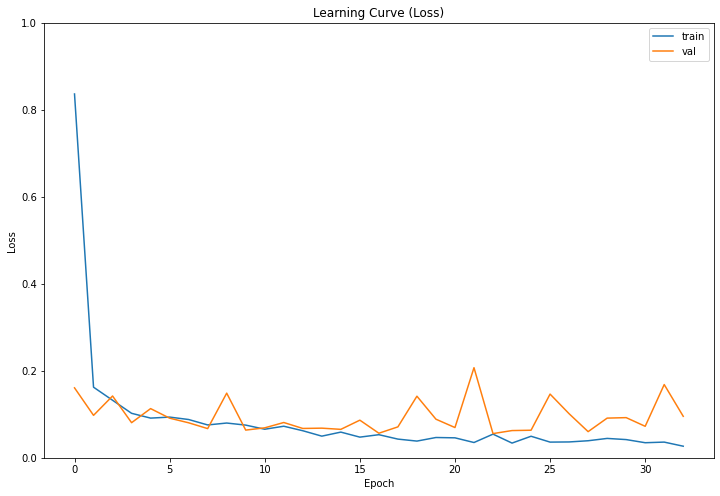

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

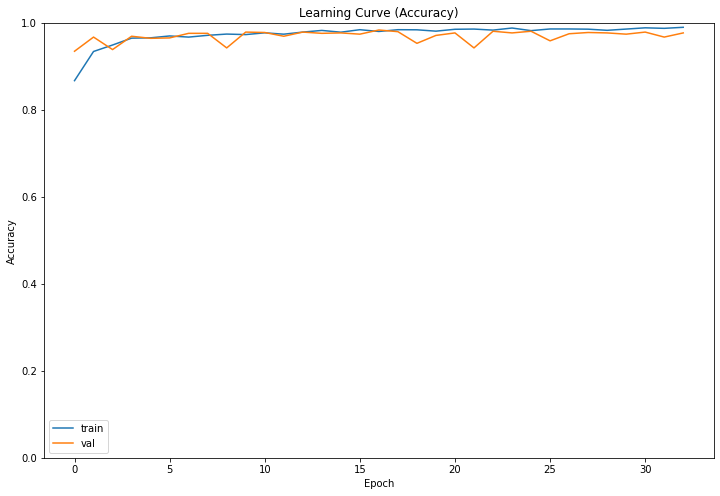

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [14]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.055659219622612
Val accuracy: 0.9808428883552551


In [15]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6557089686393738
Test accuracy: 0.8557692170143127


As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a> 

In [16]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [17]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [18]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8557692307692307


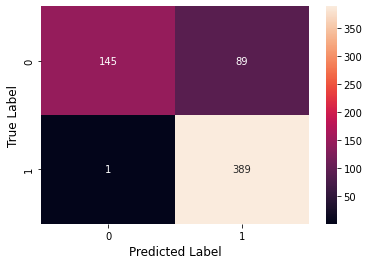

In [19]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [20]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.81      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



ROC_AUC:  0.9509368836291914


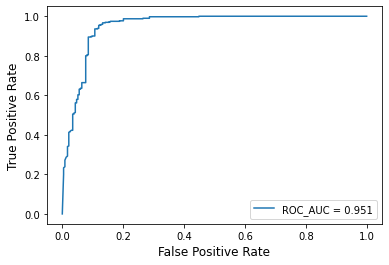

In [21]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.